In [1]:
import os
print(os.listdir('../input'))

['brain-tumor-classification-mri']


In [2]:
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
import matplotlib.colors
from sklearn.model_selection import train_test_split , GridSearchCV
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf 
from tensorflow import keras
from tqdm import tqdm 
from sklearn.utils import shuffle 
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE 
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn .ensemble import VotingClassifier 
from sklearn.metrics import accuracy_score 
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import BaggingClassifier 
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier

2024-09-08 18:11:00.199085: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-08 18:11:00.199193: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-08 18:11:00.338530: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
labels = ['glioma_tumor','no_tumor','meningioma_tumor','pituitary_tumor']
X_train =[]
Y_train =[] 
image_size =150 
for i in labels : 
    folderPath = os.path.join('../input/brain-tumor-classification-mri','Training',i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))  
        img = cv2.resize(img,(image_size,image_size))
        img = img / 255.0  # Normalize the image
        X_train.append(img) 
        Y_train.append(i)

for i in labels : 
    folderPath = os.path.join('../input/brain-tumor-classification-mri','Testing',i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))  
        img = cv2.resize(img,(image_size,image_size))
        img = img / 255.0  # Normalize the image
        X_train.append(img) 
        Y_train.append(i) 
X_train = np.array(X_train) 
Y_train = np.array(Y_train)

100%|██████████| 74/74 [00:00<00:00, 120.96it/s]


In [4]:
X_train , Y_train = shuffle(X_train ,Y_train,random_state=101)

In [5]:
X_train,X_test,Y_train,Y_test = train_test_split(X_train,Y_train, test_size=0.1,random_state=101)

In [6]:
# Reshape the 4D arrays to 2D
num_samples_train = X_train.shape[0]
num_samples_test = X_test.shape[0]

X_train_reshaped = X_train.reshape(num_samples_train, -1)  # Flatten images
X_test_reshaped = X_test.reshape(num_samples_test, -1)

# Apply PCA for dimensionality reduction
pca = PCA(n_components=0.98)
pca_train = pca.fit_transform(X_train_reshaped)
pca_test = pca.transform(X_test_reshaped)


In [7]:
# Apply SMOTE on the PCA-transformed data
smote = SMOTE()
X_resampled, Y_resampled = smote.fit_resample(pca_train, Y_train)
print(X_resampled.shape)
print(Y_resampled.shape)

(3364, 1348)
(3364,)


In [8]:
from collections import Counter
train_class_counts = Counter(Y_train)
resampled_class_counts = Counter(Y_resampled)

print("Original training class distribution:", train_class_counts)
print("Resampled class distribution:", resampled_class_counts)

Original training class distribution: Counter({'meningioma_tumor': 841, 'glioma_tumor': 833, 'pituitary_tumor': 814, 'no_tumor': 449})
Resampled class distribution: Counter({'glioma_tumor': 841, 'no_tumor': 841, 'pituitary_tumor': 841, 'meningioma_tumor': 841})


In [9]:

# Define the parameter grid for hyperparameter tuning
#param_grid = {
    #'n_estimators': [300,400, 500],
    #'max_depth': [None, 10, 20],
    
#}

#rf_clf = RandomForestClassifier()

#clf = GridSearchCV(rf_clf, param_grid, cv=5, verbose=2, n_jobs=-1)  # 5-fold cross-validation

#clf.fit(X_resampled, Y_resampled)

# Get the best parameters and best score from the grid search
#best_params = clf.best_params_
#best_score = clf.best_score_

#print(f"Best parameters found: {best_params}")
#print(f"Best cross-validation score: {best_score}")

# Use the best parameters to create the RandomForestClassifier
#best_rf_clf = RandomForestClassifier(**best_params)


# voting classifiers 

Predicting the class that receives the most votes is a relatively easy method of improving the classifier by combining the predictions of all the classifiers. We refer to this majority-vote classifier as a "hard voting classifier.

!! When all classifiers possess the capacity to estimate class probabilities ( they have a pre dict_proba() method), you may instruct Scikit-Learn to forecast the class with the highest class probability, which is the average of all the classifiers, individually. The term for this is "soft voting." As a result of giving votes with a high degree of confidence greater weight than hard voting, it frequently produces better results.

In [10]:
lr_model = LogisticRegression(multi_class='multinomial')
svm_clf = SVC(C = 10, gamma = 'scale' , kernel = 'rbf')
rf_clf = RandomForestClassifier( max_depth = 20, n_estimators = 500)
voting_clf=VotingClassifier(estimators=[('rf',rf_clf ) ,('svc',svm_clf),('lr',lr_model)],voting='hard')
voting_clf.fit(X_resampled, Y_resampled)

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


VotingClassifier(estimators=[('rf',
                              RandomForestClassifier(max_depth=20,
                                                     n_estimators=500)),
                             ('svc', SVC(C=10)),
                             ('lr',
                              LogisticRegression(multi_class='multinomial'))])

In [11]:
from sklearn.metrics import accuracy_score 
for clf in(rf_clf,svm_clf,lr_model ,voting_clf):
    clf.fit(X_resampled, Y_resampled)
    y_pred=clf.predict(pca_test)
    print(clf.__class__.__name__, accuracy_score(Y_test, y_pred))

RandomForestClassifier 0.7675840978593272
SVC 0.9051987767584098


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression 0.8256880733944955


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


VotingClassifier 0.8501529051987767


In [12]:

train_accuracy = voting_clf.score(X_resampled, Y_resampled)
print("Training Score:", train_accuracy)

Training Score: 0.9994054696789536


In [13]:
test_score = voting_clf.score(pca_test, Y_test)
print("Testing Score:", test_score)
y_pred = voting_clf.predict(pca_test)
conf_matrix = confusion_matrix(Y_test, y_pred)
class_report = classification_report(Y_test, y_pred)

print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", class_report)

Testing Score: 0.8501529051987767
Confusion Matrix:
 [[77 12  3  1]
 [12 79  2  3]
 [ 5  5 35  6]
 [ 0  0  0 87]]
Classification Report:
                   precision    recall  f1-score   support

    glioma_tumor       0.82      0.83      0.82        93
meningioma_tumor       0.82      0.82      0.82        96
        no_tumor       0.88      0.69      0.77        51
 pituitary_tumor       0.90      1.00      0.95        87

        accuracy                           0.85       327
       macro avg       0.85      0.83      0.84       327
    weighted avg       0.85      0.85      0.85       327



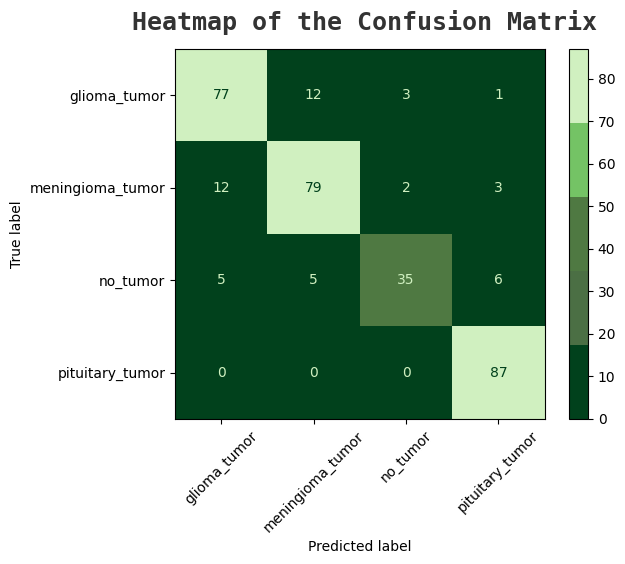

In [14]:
# Predict the response for test dataset
y_pred = voting_clf.predict(pca_test)

# Define the custom color map
custom_colors = ['#01411C','#4B6F44','#4F7942','#74C365','#D0F0C0']
custom_cmap = matplotlib.colors.ListedColormap(custom_colors)

# Calculate confusion matrix
cm = confusion_matrix(Y_test, y_pred)

# Create a display object with the custom color map
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels = ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor'])

# Plot the confusion matrix
fig, ax = plt.subplots()
disp.plot(cmap=custom_cmap, ax=ax)

# Set the title and axis labels
fig.text(s='Heatmap of the Confusion Matrix',size=18,fontweight='bold',
             fontname='monospace',y=0.92,x=0.10,alpha=0.8)

# Rotate x-axis labels
plt.xticks(rotation=45)

# Save the figure
plt.savefig('CM SVM.png', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()

# bagging


An alternative method is to train each predictor on a different random subset of the training set using the same training methodology. This technique is often to as "bagging," which is short for "bootstrap aggregating," when sampling is done with replacement. Pasting is the term for sampling that is done without a replacement.


In [15]:

svm_clf = SVC(C = 10, gamma = 'scale' , kernel = 'rbf')
bag_clf = BaggingClassifier(
    base_estimator=svm_clf,
    n_estimators=100,
    max_samples=1.0,
    bootstrap=True,
    n_jobs=-1
)

bag_clf.fit(X_resampled, Y_resampled)

y_pred = bag_clf.predict(pca_test)

accuracy = accuracy_score(Y_test, y_pred)
print(f"Accuracy: {accuracy}")

/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


Accuracy: 0.8960244648318043


In [16]:
train_accuracy = voting_clf.score(X_resampled, Y_resampled)
print("Training Score:", train_accuracy)

Training Score: 0.9994054696789536


In [17]:
test_score = bag_clf.score(pca_test, Y_test)
print("Testing Score:", test_score)
y_pred = bag_clf.predict(pca_test)
conf_matrix = confusion_matrix(Y_test, y_pred)
class_report = classification_report(Y_test, y_pred)

print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", class_report)

Testing Score: 0.8960244648318043
Confusion Matrix:
 [[76 13  3  1]
 [ 2 89  3  2]
 [ 0  4 41  6]
 [ 0  0  0 87]]
Classification Report:
                   precision    recall  f1-score   support

    glioma_tumor       0.97      0.82      0.89        93
meningioma_tumor       0.84      0.93      0.88        96
        no_tumor       0.87      0.80      0.84        51
 pituitary_tumor       0.91      1.00      0.95        87

        accuracy                           0.90       327
       macro avg       0.90      0.89      0.89       327
    weighted avg       0.90      0.90      0.89       327



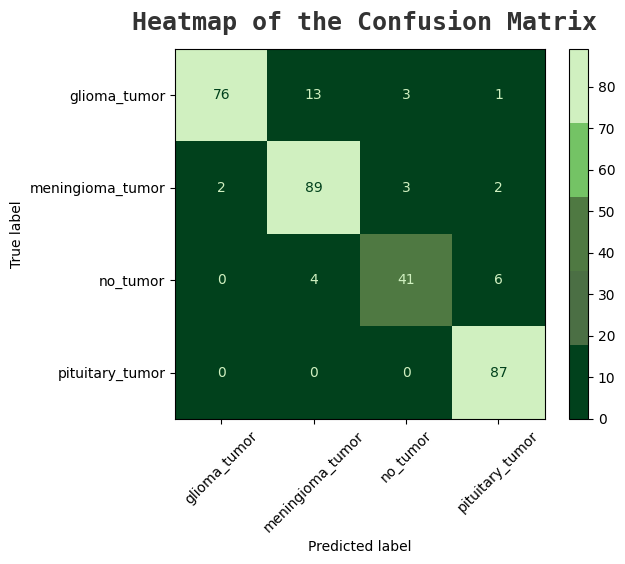

In [18]:
# Predict the response for test dataset
y_pred = bag_clf.predict(pca_test)

# Define the custom color map
custom_colors = ['#01411C','#4B6F44','#4F7942','#74C365','#D0F0C0']
custom_cmap = matplotlib.colors.ListedColormap(custom_colors)

# Calculate confusion matrix
cm = confusion_matrix(Y_test, y_pred)

# Create a display object with the custom color map
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels = ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor'])

# Plot the confusion matrix
fig, ax = plt.subplots()
disp.plot(cmap=custom_cmap, ax=ax)

# Set the title and axis labels
fig.text(s='Heatmap of the Confusion Matrix',size=18,fontweight='bold',
             fontname='monospace',y=0.92,x=0.10,alpha=0.8)

# Rotate x-axis labels
plt.xticks(rotation=45)

# Save the figure
plt.savefig('CM SVM.png', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()

The dataset is relatively small, so dividing it into different subsets results in poor accuracy. Therefore, I set max_samples to 1.0 to train on the entire dataset.

# Boosting Algorithm


One way for a new predictor to correct its predecessor is to pay a bit more attention to the training instances that the predecessor underfitted. This results in new predictors focusing more and more on the hard cases. .

# 1 adaBoost

In [19]:

svm_clf = SVC(probability=True)  # Set probability=True for SAMME and SAMME.R algorithms
ada_clf = AdaBoostClassifier(
    base_estimator=svm_clf,
    n_estimators=15,
    algorithm="SAMME.R",  # Use SAMME.R for multi-class classification
    learning_rate=0.5,
    
)

ada_clf.fit(X_resampled, Y_resampled)

y_pred = ada_clf.predict(pca_test)

accuracy = accuracy_score(Y_test, y_pred)
print(f"Accuracy: {accuracy}")

/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Accuracy: 0.746177370030581


In [20]:
train_accuracy = voting_clf.score(X_resampled, Y_resampled)
print("Training Score:", train_accuracy)

Training Score: 0.9994054696789536


In [21]:
test_score = ada_clf.score(pca_test, Y_test)
print("Testing Score:", test_score)
y_pred = ada_clf.predict(pca_test)
conf_matrix = confusion_matrix(Y_test, y_pred)
class_report = classification_report(Y_test, y_pred)

print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", class_report)

Testing Score: 0.746177370030581
Confusion Matrix:
 [[67 15  5  6]
 [33 55  2  6]
 [ 3  5 36  7]
 [ 1  0  0 86]]
Classification Report:
                   precision    recall  f1-score   support

    glioma_tumor       0.64      0.72      0.68        93
meningioma_tumor       0.73      0.57      0.64        96
        no_tumor       0.84      0.71      0.77        51
 pituitary_tumor       0.82      0.99      0.90        87

        accuracy                           0.75       327
       macro avg       0.76      0.75      0.75       327
    weighted avg       0.75      0.75      0.74       327



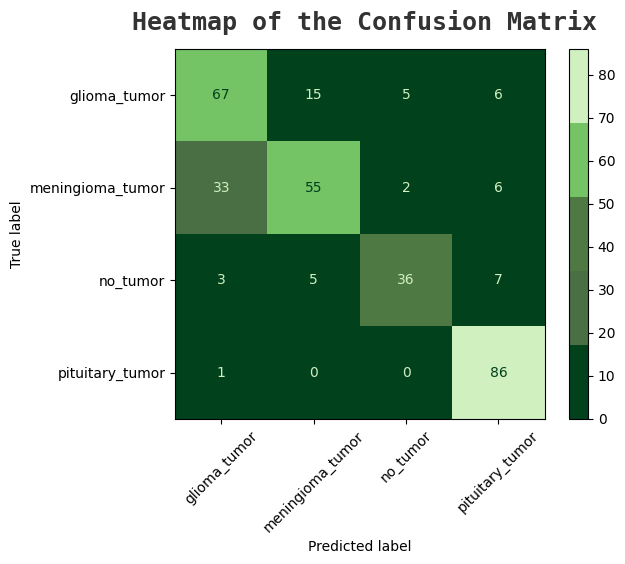

In [22]:
# Predict the response for test dataset
y_pred = ada_clf.predict(pca_test)

# Define the custom color map
custom_colors = ['#01411C','#4B6F44','#4F7942','#74C365','#D0F0C0']
custom_cmap = matplotlib.colors.ListedColormap(custom_colors)

# Calculate confusion matrix
cm = confusion_matrix(Y_test, y_pred)

# Create a display object with the custom color map
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels = ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor'])

# Plot the confusion matrix
fig, ax = plt.subplots()
disp.plot(cmap=custom_cmap, ax=ax)

# Set the title and axis labels
fig.text(s='Heatmap of the Confusion Matrix',size=18,fontweight='bold',
             fontname='monospace',y=0.92,x=0.10,alpha=0.8)

# Rotate x-axis labels
plt.xticks(rotation=45)

# Save the figure
plt.savefig('CM SVM.png', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()

# 2 gradient Boosting

In [23]:

gbc = GradientBoostingClassifier( n_estimators=40 )
gbc.fit(X_resampled, Y_resampled)
y_pred = gbc.predict(pca_test)

accuracy = accuracy_score(Y_test, y_pred)
print(f"Accuracy: {accuracy}")

Accuracy: 0.7522935779816514


In [24]:
# Calculate accuracy on training and validation sets
train_accuracy = gbc.score(X_resampled, Y_resampled)
print("Training Score:", train_accuracy)

Training Score: 0.9016052318668252


In [25]:
test_score = gbc.score(pca_test, Y_test)
print("Testing Score:", test_score)
y_pred = gbc.predict(pca_test)
conf_matrix = confusion_matrix(Y_test, y_pred)
class_report = classification_report(Y_test, y_pred)

print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", class_report)

Testing Score: 0.7522935779816514
Confusion Matrix:
 [[59 21  4  9]
 [12 74  3  7]
 [ 6  8 30  7]
 [ 1  3  0 83]]
Classification Report:
                   precision    recall  f1-score   support

    glioma_tumor       0.76      0.63      0.69        93
meningioma_tumor       0.70      0.77      0.73        96
        no_tumor       0.81      0.59      0.68        51
 pituitary_tumor       0.78      0.95      0.86        87

        accuracy                           0.75       327
       macro avg       0.76      0.74      0.74       327
    weighted avg       0.75      0.75      0.75       327



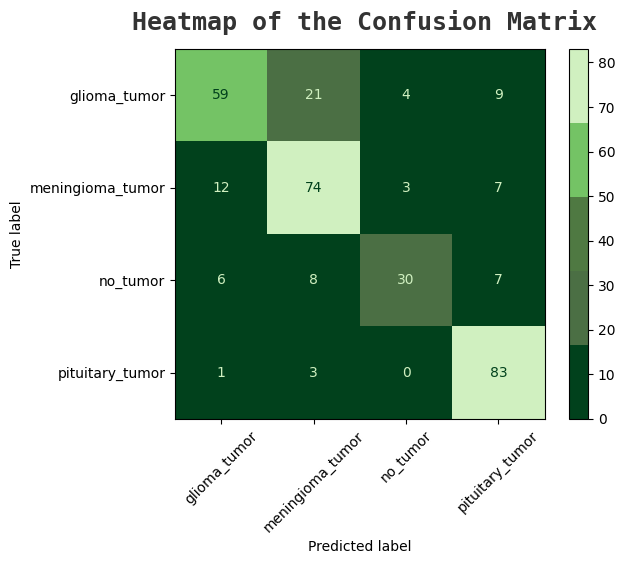

In [26]:
# Predict the response for test dataset
y_pred = gbc.predict(pca_test)

# Define the custom color map
custom_colors = ['#01411C','#4B6F44','#4F7942','#74C365','#D0F0C0']
custom_cmap = matplotlib.colors.ListedColormap(custom_colors)

# Calculate confusion matrix
cm = confusion_matrix(Y_test, y_pred)

# Create a display object with the custom color map
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels = ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor'])

# Plot the confusion matrix
fig, ax = plt.subplots()
disp.plot(cmap=custom_cmap, ax=ax)

# Set the title and axis labels
fig.text(s='Heatmap of the Confusion Matrix',size=18,fontweight='bold',
             fontname='monospace',y=0.92,x=0.10,alpha=0.8)

# Rotate x-axis labels
plt.xticks(rotation=45)

# Save the figure
plt.savefig('CM SVM.png', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()